In [1]:
import numpy as np
import pandas as pd 
import torch
import cv2
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import random
import pickle
from skimage import io
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
# Load the CSV file into a DataFrame
file_path = "/Users/camilledelannoy/Desktop/Deep Learning/Group/train.csv" # replace with train.csv file path
df = pd.read_csv(file_path)

# Define the old base path and the new base path
old_base_path = "../input/english-premier-league-logo-detection-20k-images/epl-logos-big/epl-logos-big/"
new_base_path = "/Users/camilledelannoy/Desktop/Deep Learning/Group/logos/epl-logos-big/" # replace with the "epl logos big" folder path

# Replace the old base path with the new base path in the 'filepath' column
df['filepath'] = df['filepath'].str.replace(old_base_path, new_base_path)

# Save the updated DataFrame back to a CSV file
updated_file_path = "/Users/camilledelannoy/Desktop/Deep Learning/Group/train_updated.csv"
df.to_csv(updated_file_path, index=False)

print(f"File paths updated and saved to {updated_file_path}")

File paths updated and saved to /Users/camilledelannoy/Desktop/Deep Learning/Group/train_updated.csv


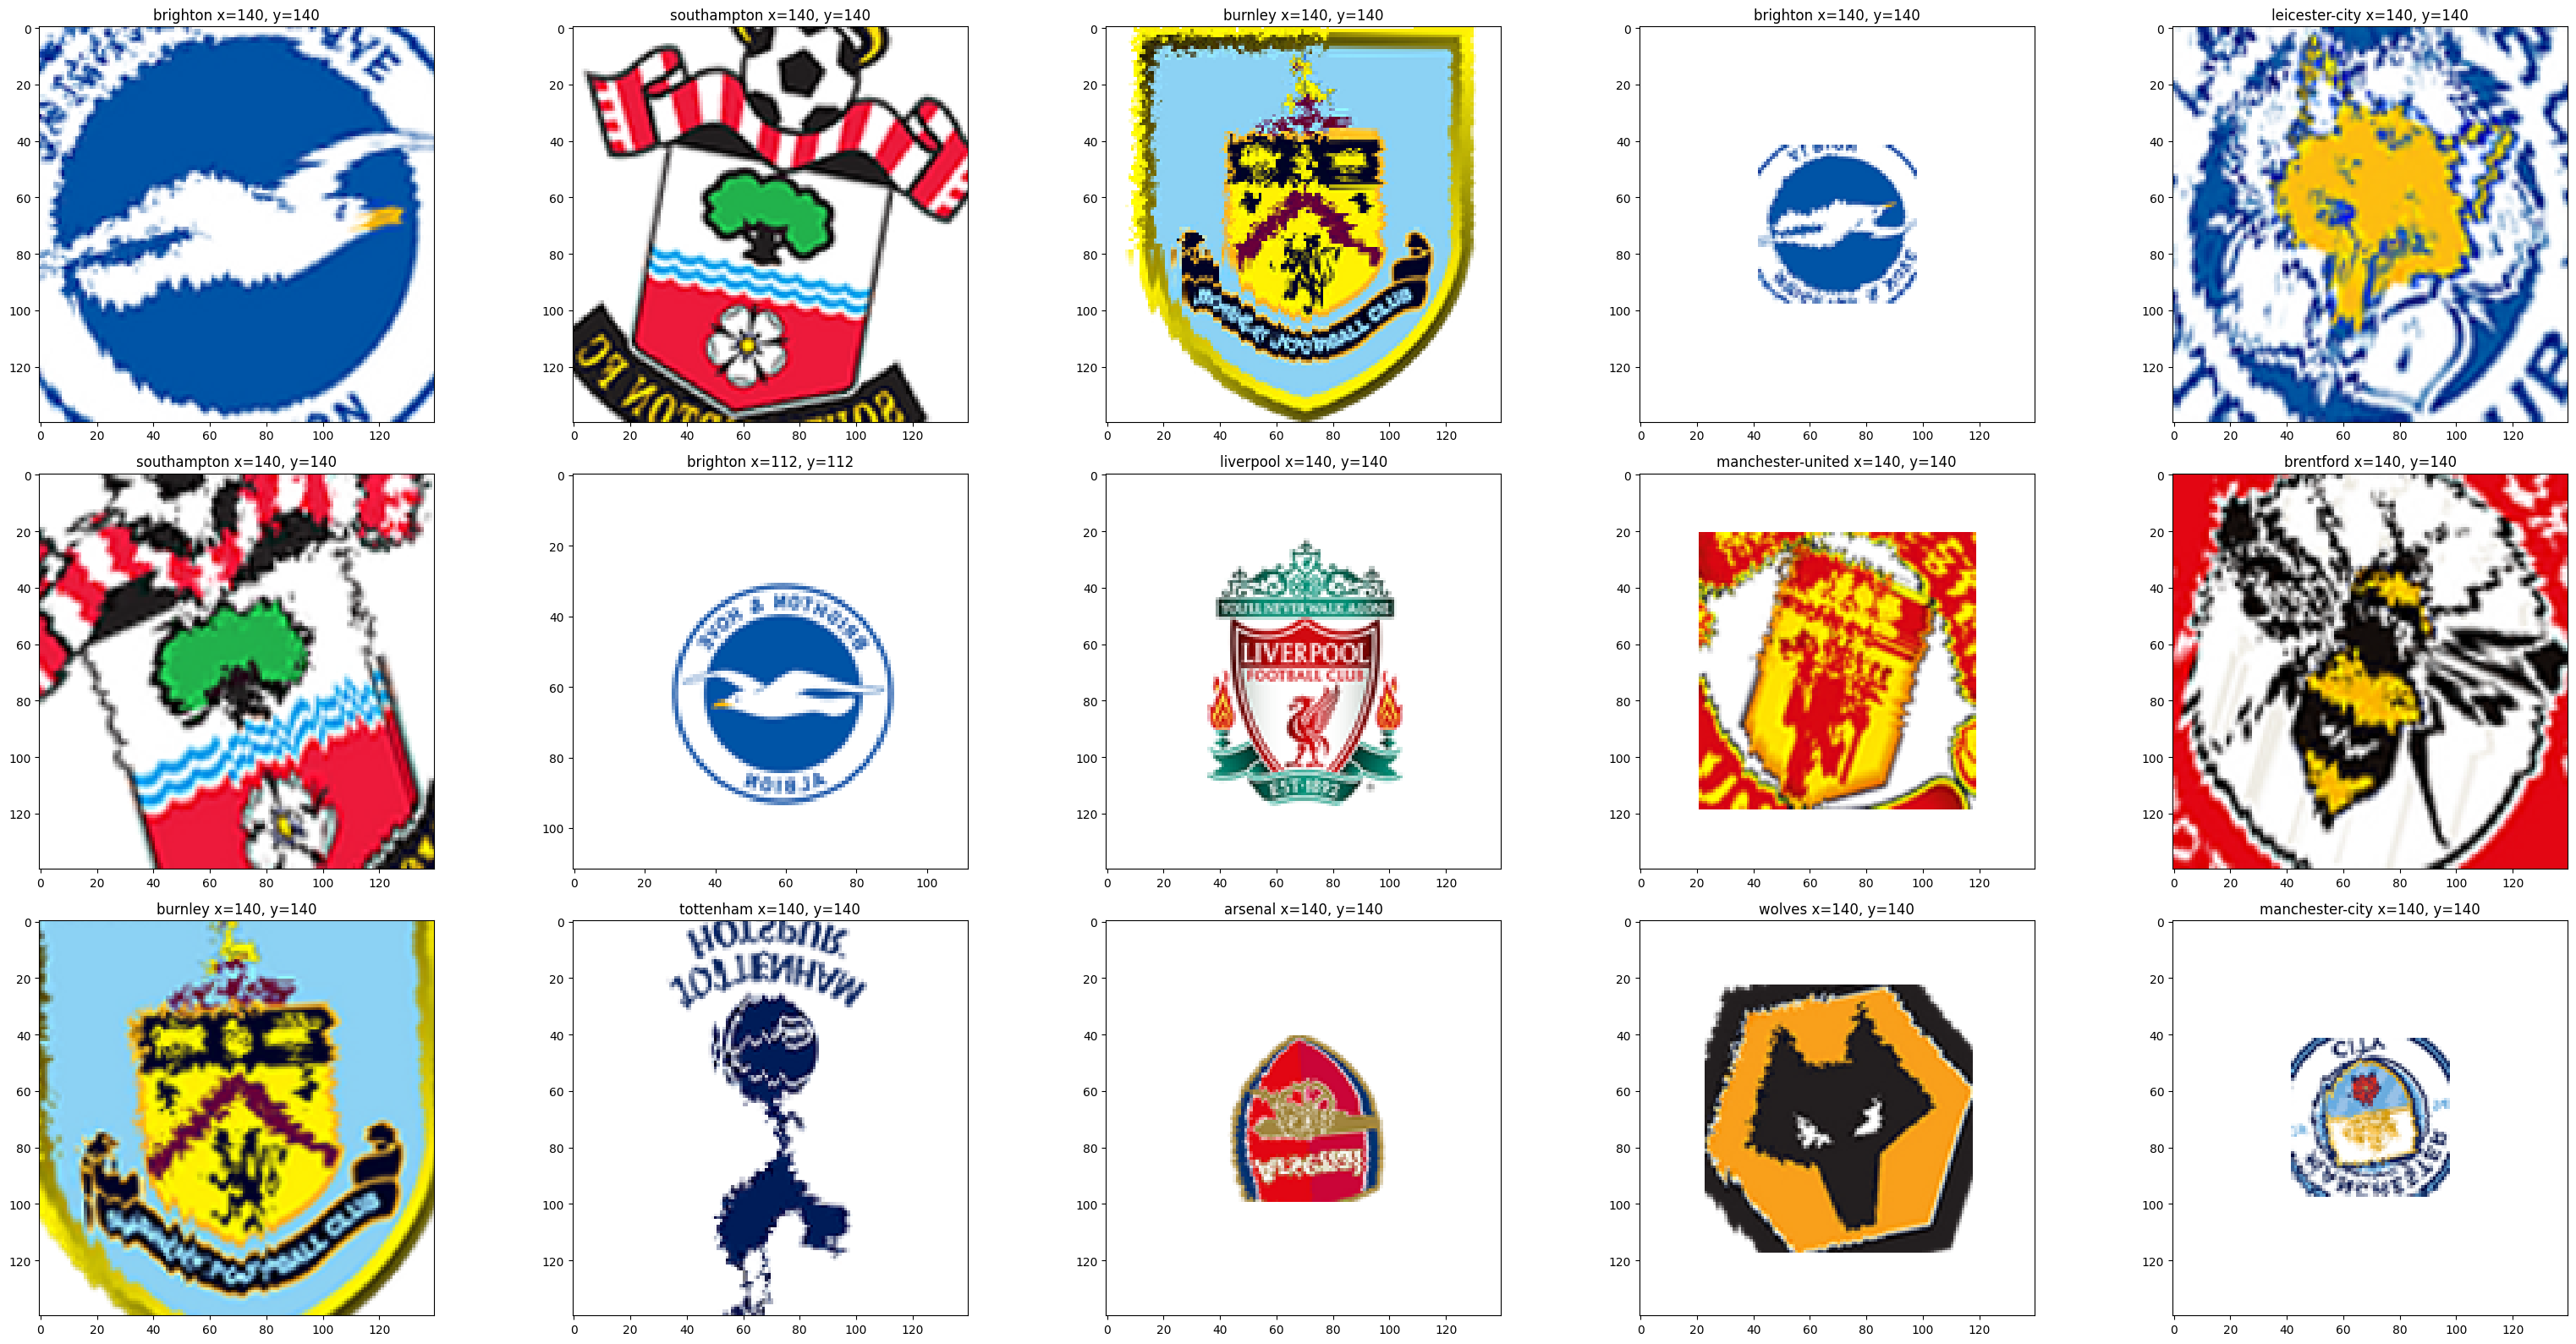

In [4]:
# Read the CSV file into a DataFrame
os.chdir('/Users/camilledelannoy/Desktop/Deep Learning/Group')
df = pd.read_csv("train_updated.csv")

filepath_column = 'filepath' 
team_name_column = 'team_name'  

# Base path for the images
base_image_path = "/Users/camilledelannoy/Desktop/Deep Learning/Group/logos/epl-logos-big"

# Number of rows and columns for the subplot grid
n1 = 3
n2 = 5
fig, axs = plt.subplots(n1, n2, figsize=(32, 16))

for i in range(n1):
    for j in range(n2):
        z = random.randint(0, len(df)-1)
        # Construct the full file path for the image
        image_path = os.path.join(base_image_path, df.loc[z][filepath_column])
        # Read the image using skimage.io.imread
        pic = np.array(io.imread(image_path))
        shape = np.shape(pic)
        axs[i, j].imshow(pic)
        axs[i, j].set_title('%s x=%.f, y=%.f' % (df.loc[z][team_name_column], shape[0], shape[1]))

# Adjust layout to prevent overlap of titles and images
plt.tight_layout()
plt.show()

Average height 135.38


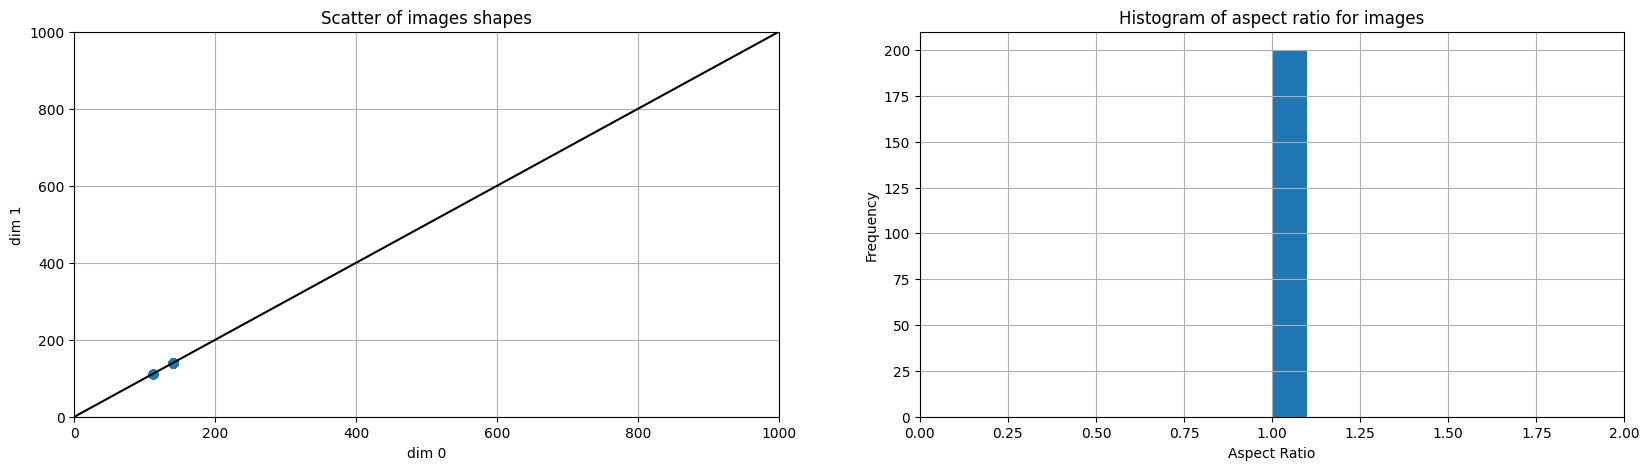

In [5]:
# Sample a fraction of the DataFrame
sample_df = df.sample(frac=0.01, ignore_index=True)

N = len(sample_df)
shape = np.zeros((2, N))

for i in range(N):
    # Construct the full file path for the image
    image_path = os.path.join(base_image_path, sample_df.loc[i][filepath_column])
    # Read the image using skimage.io.imread
    tmp = np.shape(np.array(io.imread(image_path, as_gray=True)))
    shape[:, i] = [tmp[0], tmp[1]]

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].scatter(shape[0, :], shape[1, :])
axs[0].plot(range(0, 1000), range(0, 1000), 'k')
axs[0].set_ylabel('dim 1')
axs[0].set_xlabel('dim 0')
axs[0].grid()
axs[0].set_title('Scatter of images shapes')
axs[0].set_xlim([0, 1000])
axs[0].set_ylim([0, 1000])

axs[1].hist(shape[0, :]/shape[1, :])
axs[1].grid()
axs[1].set_xlabel('Aspect Ratio')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of aspect ratio for images')
axs[1].set_xlim([0, 2])

print("Average height " + str(np.mean(shape[1, :])))
plt.show()

In [6]:
# Encode the team names to integers
label_encoder = LabelEncoder()
df[team_name_column] = label_encoder.fit_transform(df[team_name_column])

# Define transformations with conversion to RGB for images with 4 channels
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),  # Resize to a consistent size
    transforms.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),  # Convert to RGB if not already
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.dataframe.iloc[idx, 0])
        image = io.imread(img_name)
        label = self.dataframe.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Create the dataset
dataset = CustomDataset(df, base_image_path, transform=transform)

# Split the dataset into training and validation sets
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
num_classes = len(label_encoder.classes_)
model = SimpleCNN(num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the validation images: {100 * correct / total}%')


Epoch 1/10, Loss: 0.1772477942721016
Epoch 2/10, Loss: 0.008902704377841018
Epoch 3/10, Loss: 0.0016950737741246939
Epoch 4/10, Loss: 0.00010832598998601384
Epoch 5/10, Loss: 2.9098693709396884e-05
Epoch 6/10, Loss: 1.6741244560776637e-05
Epoch 7/10, Loss: 1.1054558973890848e-05
Epoch 8/10, Loss: 7.610132898483446e-06
Epoch 9/10, Loss: 5.410007546869267e-06
Epoch 10/10, Loss: 3.97548993136132e-06
Accuracy of the model on the validation images: 99.975%


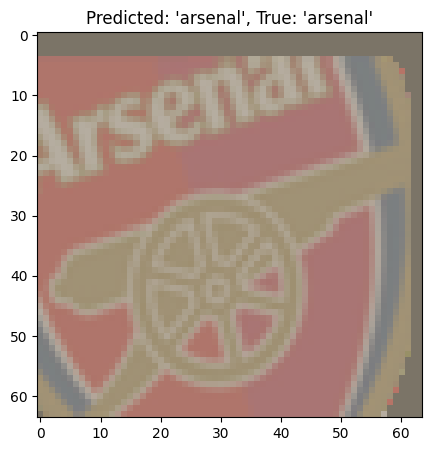

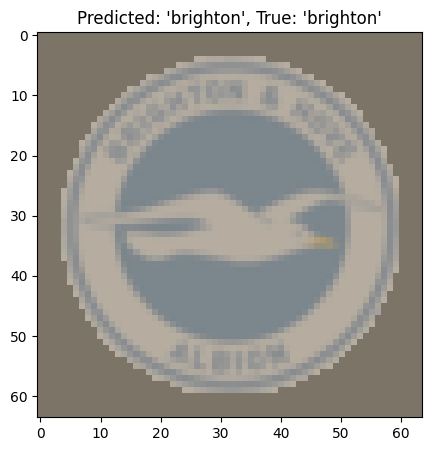

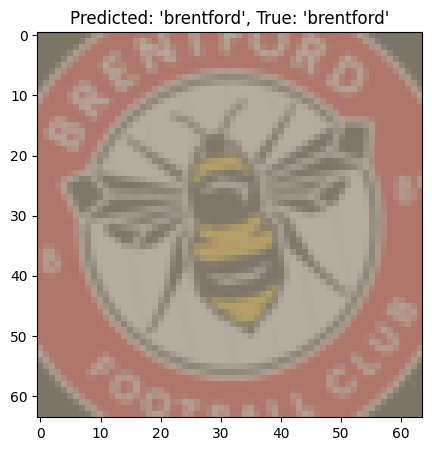

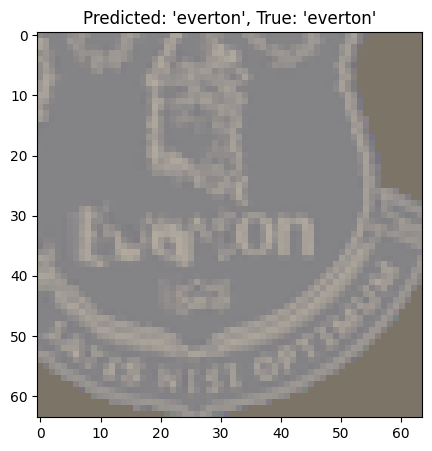

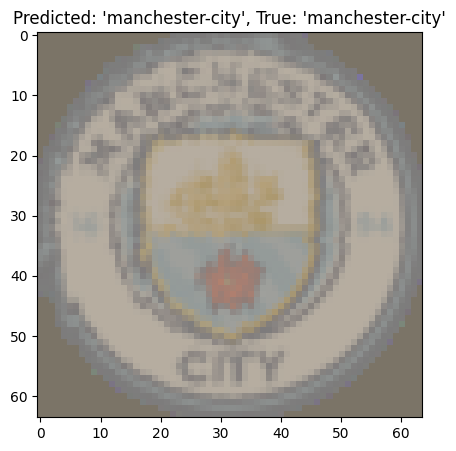

In [7]:
# Create df to map team labels to team names
teams = pd.read_csv("train_updated.csv")
teams = teams[['team_name', 'team']].drop_duplicates().reset_index(drop=True)

# 'team' for the integer label, and 'team_name' for the corresponding team name
integer_label_column = 'team'  # The column with integer labels
team_name_column = 'team_name'  # The column with team names

# Function to unnormalize and show images with predictions
def imshow(img, title):
    # Unnormalize the image
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    npimg = img.numpy()
    plt.figure(figsize=(10, 5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

# Set the model to evaluation mode
model.eval()

# Get a batch of test data
dataiter = iter(val_loader)
images, labels = next(dataiter)

# Make predictions
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Convert predictions and labels to numpy for display
predicted_np = predicted.cpu().numpy()
labels_np = labels.cpu().numpy()

# Display random images with predictions and true labels
for i in range(5):
    index = random.randint(0, images.size(0) - 1)
    img = images[index]
    pred_label = predicted_np[index]
    true_label = labels_np[index]
    
    # Get the corresponding team name from 'teams' DataFrame for both predicted and true labels
    pred_class = teams[teams[integer_label_column] == pred_label][team_name_column].iloc[0]
    true_class = teams[teams[integer_label_column] == true_label][team_name_column].iloc[0]
    
    # Unnormalize the image for display
    img_unnorm = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    
    imshow(img_unnorm, f"Predicted: '{pred_class}', True: '{true_class}'")


In [8]:
# Function to preprocess the frame
def preprocess_frame(frame):
    # Resize the frame to match the input size expected by the model
    frame = cv2.resize(frame, (64, 64))
    # Convert the frame to the format expected by PyTorch models (RGB, float32, normalized)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = frame.astype(np.float32) / 255.0
    frame = (frame - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
    # Convert the frame to a PyTorch tensor
    frame = torch.from_numpy(frame.transpose((2, 0, 1))).float()
    # Add a batch dimension
    frame = frame.unsqueeze(0)
    return frame

# Initialize the webcam
cap = cv2.VideoCapture(0)

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Preprocess the frame
    input_tensor = preprocess_frame(frame)

    # Make predictions
    outputs = model(input_tensor)

    # Get predicted label
    _, predicted = torch.max(outputs, 1)
    predicted_label = predicted.item()

    # Get the corresponding team name from 'teams' DataFrame
    pred_class = teams[teams[integer_label_column] == predicted_label][team_name_column].iloc[0]

    # Display the frame with the predicted label
    cv2.putText(frame, f"Predicted: {pred_class}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow('frame', frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close OpenCV windows
cap.release()
cv2.destroyAllWindows()


2024-05-20 14:08:31.981 Python[80186:29930442] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
